

*   Nama : Fauzan Kamil 
*   Univ : Universitas Bhayangkara Jakarta Raya




In [2]:
#Install library
!pip install d2l==0.17.0 

In [3]:
!pip install -U mxnet-cu101==1.7.0

In [4]:
%matplotlib inline
from mxnet import autograd, gluon, image, init, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

In [5]:
npx.set_np()

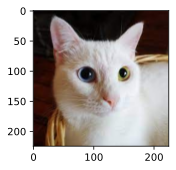

In [6]:
d2l.set_figsize()
img = image.imread('cat1.jpg') #Membaca gambar
d2l.plt.imshow(img.asnumpy()); #Menampilkan gambar

In [7]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

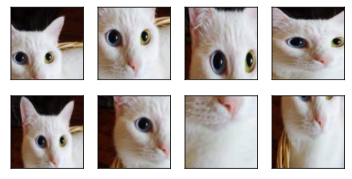

In [8]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

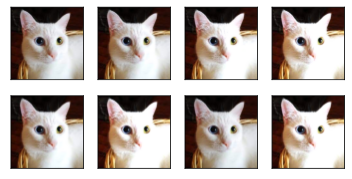

In [9]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

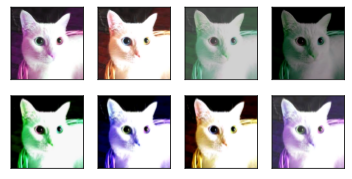

In [10]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

In [11]:
coba = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])

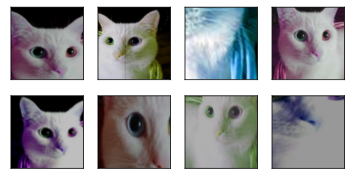

In [12]:
apply(img, coba)

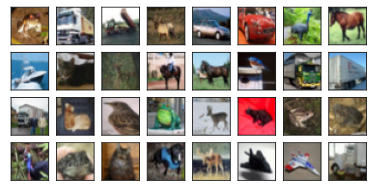

In [45]:
d2l.show_images(
    gluon.data.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=0.8);

In [33]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.RandomFlipTopBottom(), #Ditambah
    gluon.data.vision.transforms.RandomHue(0.5), #Ditambah
    gluon.data.vision.transforms.RandomBrightness(0.5), #Ditambah
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

In [34]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

In [35]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, devices,
                     split_f=d2l.split_batch):
    """Train for a minibatch with mutiple GPUs (defined in Chapter 13)."""
    X_shards, y_shards = split_f(features, labels, devices)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [
            loss(pred_shard, y_shard)
            for pred_shard, y_shard in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The `True` flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(
        d2l.accuracy(pred_shard, y_shard)
        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [36]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus(), split_f=d2l.split_batch):
    """Train a model with mutiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer,
                                      devices, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [48]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=devices)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

loss 0.436, train acc 0.849, test acc 0.780
612.1 examples/sec on [gpu(0)]
CPU times: user 14min 47s, sys: 14 s, total: 15min 1s
Wall time: 15min 8s


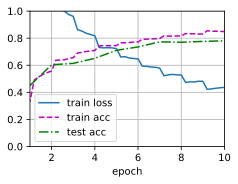

In [38]:
%%time
train_with_data_aug(train_augs, test_augs, net)

#Jawab: 

1.   Mengurangi overvitting, karena memiliki dataset yang lebih beragam dan lebih besar dengan menambah variasi pada data asli seperti membalik gambar.
2.   Tidak meningkatkan akurasi justru mengurangi akurasi, sebelum ditambah akurasi nya train acc 0.941, test acc 0.828 setelah di tambah train acc 0.849, test acc 0.780
3. tidak ada metode selain yang sudah dijelaskan pada pertemuan 50 kemaren di dalam deep learning framework yang di akses (https://d2l.ai/chapter_computer-vision/image-augmentation.html).

